# Time Series Forecasting with Scikit-learn

Goals:

- Introduce tabularization of time-series data to use
- Explore the use of Quantile Regression with Gradient Boosting models to estimate uncertainties in predictions;
- Explore different ways to evaluate the quality of our models;
- Automate some of what we did with `sktime`.


First let's check that the following libraries are installed:

In [1]:
import sklearn
import matplotlib
import pandas

sklearn.__version__

'1.1.2'

The following cell is not necessarily needed but can help avoid some slowdowns when running this notebooks on some machines.

In [2]:
import threadpoolctl
import joblib


n_physical_cpus = joblib.cpu_count(only_physical_cores=True)
threadpoolctl.threadpool_limits(limits=n_physical_cpus);
threadpoolctl.threadpool_info()

[{'user_api': 'blas',
  'internal_api': 'openblas',
  'prefix': 'libopenblas',
  'filepath': '/Users/ogrisel/mambaforge/envs/stable/lib/libopenblas.0.dylib',
  'version': '0.3.21',
  'threading_layer': 'openmp',
  'architecture': 'VORTEX',
  'num_threads': 8},
 {'user_api': 'openmp',
  'internal_api': 'openmp',
  'prefix': 'libomp',
  'filepath': '/Users/ogrisel/mambaforge/envs/stable/lib/libomp.dylib',
  'version': None,
  'num_threads': 8}]

## Data exploration on the Bike Sharing Demand dataset

We start by loading the data from the OpenML repository.

In [3]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True
)
df = bike_sharing.frame
count = df["count"]

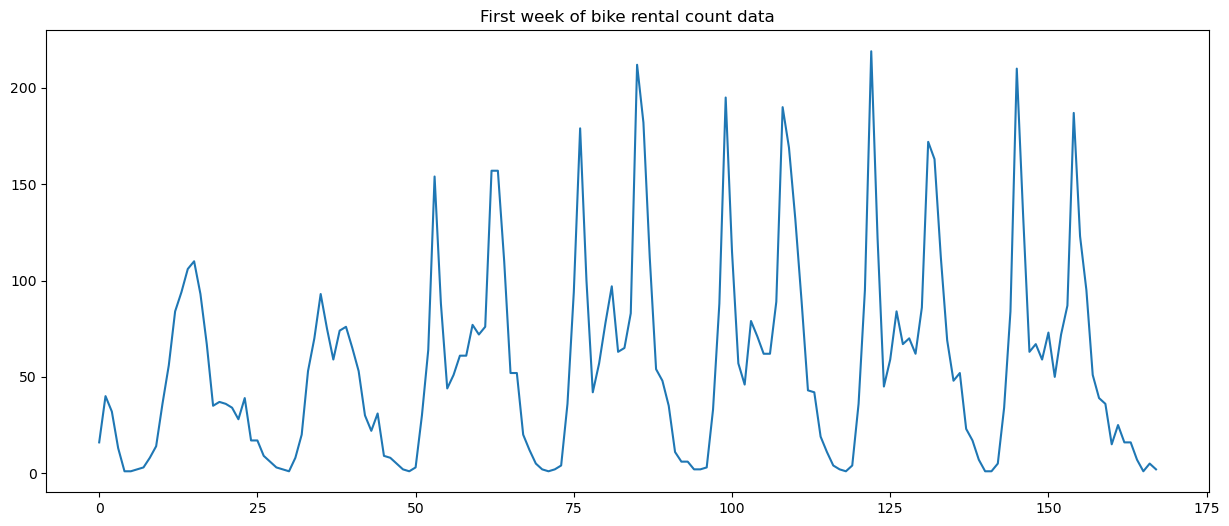

In [4]:
import matplotlib.pyplot as plt


count[:7 * 24].plot(figsize=(15, 6))
_ = plt.title("First week of bike rental count data")

In [5]:
count.describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: count, dtype: float64

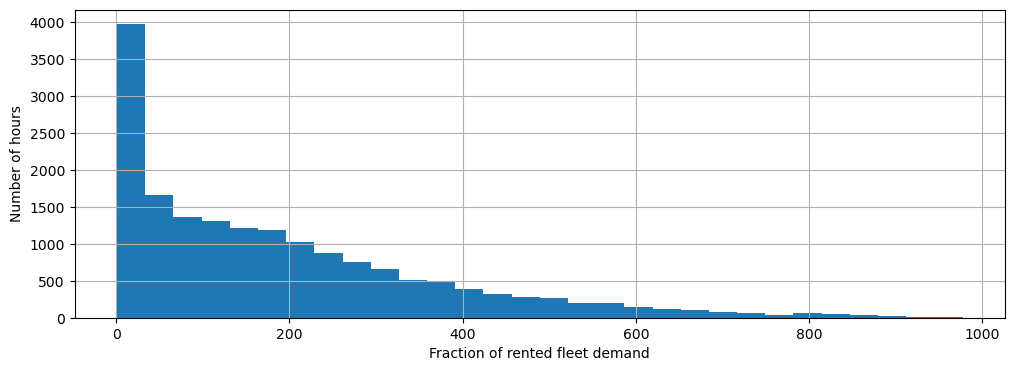

In [6]:
fig, ax = plt.subplots(figsize=(12, 4))
count.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

## Time-series Forecasting via Tabularization

Let's consider the problem of predicting the demand at the next hour given past demands.

Since the demand is a continuous variable, one could intuitively use any regression model.

However we don't have the usual `(X_train, y_train)` dataset.

Instead we just have `y_train` demand data sequentially organized by time.


**TODO** draw a nice diagram here!

In [7]:
count.tail(10)

17369    247.0
17370    315.0
17371    214.0
17372    164.0
17373    122.0
17374    119.0
17375     89.0
17376     90.0
17377     61.0
17378     49.0
Name: count, dtype: float64

In [8]:
import pandas as pd

lagged_df = pd.concat(
    [
        count,
        count.shift(1).rename("count_lagged_1h"),
        count.shift(2).rename("count_lagged_2h"),
        count.shift(3).rename("count_lagged_3h"),
        count.shift(24).rename("count_lagged_1d"),
        count.shift(24 + 1).rename("count_lagged_1d_1h"),
        count.shift(7 * 24).rename("count_lagged_7d"),
        count.shift(7 * 24 + 1).rename("count_lagged_7d_1h"),
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
)
lagged_df.tail(10)

,count,count_lagged_1h,count_lagged_2h,count_lagged_3h,count_lagged_1d,count_lagged_1d_1h,count_lagged_7d,count_lagged_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
17369,247.0,203.0,224.0,157.0,160.0,169.0,70.0,135.0,93.500000,224.0,1.0,67.732143,271.0,1.0
17370,315.0,247.0,203.0,224.0,138.0,160.0,46.0,70.0,97.125000,247.0,1.0,68.785714,271.0,1.0
17371,214.0,315.0,247.0,203.0,133.0,138.0,33.0,46.0,104.500000,315.0,1.0,70.386905,315.0,1.0
17372,164.0,214.0,315.0,247.0,123.0,133.0,33.0,33.0,107.875000,315.0,1.0,71.464286,315.0,1.0
17373,122.0,164.0,214.0,315.0,125.0,123.0,26.0,33.0,109.583333,315.0,1.0,72.244048,315.0,1.0
17374,119.0,122.0,164.0,214.0,102.0,125.0,26.0,26.0,109.458333,315.0,1.0,72.815476,315.0,1.0
17375,89.0,119.0,122.0,164.0,72.0,102.0,18.0,26.0,110.166667,315.0,1.0,73.369048,315.0,1.0
17376,90.0,89.0,119.0,122.0,47.0,72.0,23.0,18.0,110.875000,315.0,1.0,73.791667,315.0,1.0
17377,61.0,90.0,89.0,119.0,36.0,47.0,22.0,23.0,112.666667,315.0,1.0,74.190476,315.0,1.0
17378,49.0,61.0,90.0,89.0,49.0,36.0,12.0,22.0,113.708333,315.0,1.0,74.422619,315.0,1.0


Whatch out however, the first lines have undefined values because their own past is unknown. This depends on how much lag we used:

In [9]:
lagged_df.head(10)

,count,count_lagged_1h,count_lagged_2h,count_lagged_3h,count_lagged_1d,count_lagged_1d_1h,count_lagged_7d,count_lagged_7d_1h,lagged_mean_24h,lagged_max_24h,lagged_min_24h,lagged_mean_7d,lagged_max_7d,lagged_min_7d
0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,32.0,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13.0,32.0,40.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,13.0,32.0,40.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,1.0,13.0,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2.0,1.0,1.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8.0,3.0,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,14.0,8.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can now separate the lagged features in a matrix `X` and the target variable (the counts to predict) in an array of the same first dimension `y`.

In [10]:
lagged_df = lagged_df.dropna()

In [11]:
X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]

In [12]:
X.shape

(17210, 13)

In [13]:
y.shape

(17210,)

## Naive Regression of the Next Hour Bike Demand

Let's randomly split our tabularized dataset to train a gradient boosting regression tree (GBRT) model and evaluate it using the [Mean Absolute Percentage Error](https://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-percentage-error).

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = HistGradientBoostingRegressor().fit(X_train, y_train)

In [17]:
from sklearn.metrics import mean_absolute_percentage_error


y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.38580551307744854

### Questions

- Why this way of evaluating the predictive performance of our model naive?
    - Hint: this train-test split is only valid for *independent and identically distributed data*.
- What should be done instead?

## Proper Next Hour Forecasting Evaluation

Let's use a proper evaluation splitting strategies that takes into account the temporal structure of the dataset to **evaluate our model's ability to predict data points in the future** (to avoid cheating by reading values from the lagged features in the training set).

In [23]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=3,            # to keep the notebook fast on common laptops
    gap=48,                # 2 days data gap between train and test
    max_train_size=10000,  # quite arbitrary
    test_size=3000,        # need at lest this to hope for 2 or 3 digits of precision in scores
)

In [51]:
all_splits = list(ts_cv.split(X, y))
len(all_splits)

3

In [52]:
train_idx, test_idx = all_splits[0]
X_train, X_test, y_train, y_test = X.iloc[train_idx], X.iloc[test_idx], y.iloc[train_idx], y.iloc[test_idx]


model = HistGradientBoostingRegressor().fit(X_train, y_train)
y_pred = model.predict(X_test)
mean_absolute_percentage_error(y_test, y_pred)

0.44300751539296973

The error rate of this model is better than our naive shuffling train-test split. This is quite expected but maybe the first split is easier to predict (more regular) than the others. Let's assess this variability of our error evaluation with proper cross-validation:

In [53]:
from sklearn.model_selection import cross_val_score


cv_mape_scores = -cross_val_score(model, X, y, cv=ts_cv, scoring="neg_mean_absolute_percentage_error")
cv_mape_scores

array([0.44300752, 0.27772182, 0.3697178 ])

The variability accross splits is huge: in a real life setting it would be advised to use more splits to better assess the variability. Let's report the mean CV scores and their standard deviation from now on.

In [54]:
print(f"CV MAPE: {cv_mape_scores.mean():.3f} ± {cv_mape_scores.std():.3f}")

CV MAPE: 0.363 ± 0.068


To get a finer evaluation of our models we can compute and report several cross-validation metrics at once using a dedicated helper function:

In [55]:
import numpy as np
from time import perf_counter
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error


def evaluate(model, X, y, cv):
    def score_func(estimator, X, y):
        y_pred = estimator.predict(X)
        return {
            "mean_absolute_percentage_error": mean_absolute_percentage_error(y, y_pred),
            "root_mean_squared_error": np.sqrt(mean_squared_error(y, y_pred)),
            "mean_absolute_error": mean_absolute_error(y, y_pred),
            "mean_pinball_05_loss": mean_pinball_loss(y, y_pred, alpha=0.05),
            "mean_pinball_50_loss": mean_pinball_loss(y, y_pred, alpha=0.50),
            "mean_pinball_95_loss": mean_pinball_loss(y, y_pred, alpha=0.95),
        }
    tic = perf_counter()
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=score_func,
    )
    toc = perf_counter()
    for key, value in cv_results.items():
        if key.startswith("test_"):
            print(f"{key[5:]}: {value.mean():.3f} ± {value.std():.3f}")
    print(f"\ndone in {toc - tic:.3f} s")

In [56]:
from sklearn.ensemble import HistGradientBoostingRegressor


gbrt_mse = HistGradientBoostingRegressor(loss="squared_error")
evaluate(gbrt_mse, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.363 ± 0.068
root_mean_squared_error: 62.343 ± 3.523
mean_absolute_error: 39.088 ± 2.268
mean_pinball_05_loss: 17.700 ± 1.275
mean_pinball_50_loss: 19.544 ± 1.134
mean_pinball_95_loss: 21.388 ± 2.363

done in 3.022 s


In [31]:
gbrt_poisson = HistGradientBoostingRegressor(loss="poisson")
evaluate(gbrt_poisson, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.316 ± 0.069
root_mean_squared_error: 64.186 ± 4.050
mean_absolute_error: 39.307 ± 2.808
mean_pinball_05_loss: 16.669 ± 1.541
mean_pinball_50_loss: 19.653 ± 1.404
mean_pinball_95_loss: 22.638 ± 2.983

done in 2.774 s


### Analysis

Compare the results of those first two models, what do you observe?

- which model has the best MAPE?
- which model has the best RMSE?
- in your opinion, since the `squared_error` model directly optimize for the RMSE objective, do you expect to always reach the best RMSE? Why?

### Exercise: baseline (generalized) linear models

- Evaluate `sklearn.linear_model.Ridge` and `sklearn.linear_model.PoissonRegressor` on the previous feature array. Here the data has many more samples than features so it is advised to use a low enough value for the regularization parameter `alpha` of both models, e.g. `alpha=0.0001` but feel free to try other values.
- For `Ridge`, it is recommended to use `solver="lsqr"` which has proven to be more numerically stable (and fast) than alternatives on this dataset.
- Which of the 2 models performs best in terms of MAPE or Mean Squared Error?
- Are those models competitive in terms of training speed and cross-validated metrics compared to the tree based models?



In [52]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import PoissonRegressor


# TODO put your code here

















### Solution

In [36]:
from sklearn.linear_model import Ridge


evaluate(Ridge(alpha=1e-4, solver="lsqr"), X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.662 ± 0.147
root_mean_squared_error: 66.739 ± 3.712
mean_absolute_error: 43.205 ± 2.983
mean_pinball_05_loss: 21.685 ± 1.876
mean_pinball_50_loss: 21.602 ± 1.491
mean_pinball_95_loss: 21.519 ± 1.780

done in 0.017 s


In [57]:
from sklearn.linear_model import PoissonRegressor


evaluate(PoissonRegressor(alpha=1e-4), X, y, cv=ts_cv)

mean_absolute_percentage_error: 5.638 ± 1.625
root_mean_squared_error: 212.824 ± 29.798
mean_absolute_error: 162.238 ± 24.538
mean_pinball_05_loss: 54.570 ± 9.235
mean_pinball_50_loss: 81.119 ± 12.269
mean_pinball_95_loss: 107.668 ± 26.722

done in 0.014 s


We observe that the `PoissonRegressor` model is much worse than the `Ridge` model when trained on the raw features but even the latter is not very good (e.g. a bit lower than 60% MAPE), this is much worth than the Gradient Boosting based models. One reason could be that tree-based model can naturally model non-linear statistical association between the raw `X` features and the `y` target values.

**Note**: the solver for `PoissonRegressor` does not seem to work at all the raw features. I suspect ill-conditioning of the resulting optimization problem causing the `l-BFGS` solver to fail (silently!) in this case. There is work in progress to plug alternative solvers for this estimator in scikit-learn.


## Non-linear Feature Engineering with `SplineTransformer`

Let's now consider a non-linear feature transformation (expansion) using spline functions. We hope to make the combination (spline transformer + linear model) more expressive than a linear model trained directly on the raw features.


Here is are the dimensions of the feature matrix before and after transformation by the `SplineTransformer` of scikit-learn:

In [58]:
X.shape

(17210, 13)

In [59]:
from sklearn.preprocessing import SplineTransformer


SplineTransformer(n_knots=10, degree=3).fit_transform(X).shape

(17210, 156)


You can observe that the spline-based transformation created many more derived features than originally. With this additional expressive power, one could hope that the models are no longer under fitting.

Each input feature is expanded into several features via a polynomial transformation (depending on the number of spline knots and degrees). Contrary to traditional polynomial transformation, splines features are bounded and non-monotonic:

![Spline Features (4 knots)](https://scikit-learn.org/stable/_images/sphx_glr_plot_polynomial_interpolation_002.png)


### Exercise

- Define and evaluate a pipeline of `sklearn.preprocessing.SplineTransformer` and `sklearn.linear_model.PoissonRegressor` on the same problem.
- You can use the `sklearn.pipeline.make_pipeline` function to combine the two estimators into a compound non-linear regression model that does the spline expansion internally.


**Note**: the current solver of `PoissonRegressor` (L-BFGS) is known to have trouble on this kind of features but I don't have a good solution for now, feel free to keep `max_iter=100` and silence the warning hoping that convergence is good enough.

- What do you observe?
- Are this compound model better than fitting `sklearn.linear_model.PoissonRegressor`  directly on `X` and `y`


In [60]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline


# TODO: put your code here




















### Solution

In [68]:
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.pipeline import make_pipeline


pipeline = make_pipeline(
    SplineTransformer(n_knots=12, degree=3),
    PoissonRegressor(alpha=1e-6, max_iter=300),
)

with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    evaluate(pipeline, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.405 ± 0.077
root_mean_squared_error: 90.063 ± 27.977
mean_absolute_error: 55.027 ± 18.661
mean_pinball_05_loss: 16.299 ± 2.366
mean_pinball_50_loss: 27.513 ± 9.330
mean_pinball_95_loss: 38.727 ± 20.119

done in 1.692 s


## Using Neural Networks

We can also compare this to another smooth non-linear model, namely a fully-connected feed forward neural network traditionally called a Multi Layer Perceptron.

This model is quite sensitive to hyper-parameter settings and to input feature scaling. Here we use `QuantileTransformer` which usually works quite well for MLPs. We keep the size small enough to keep the runtime acceptable while reaching comparable performance to our spline-base pipeline.

In [69]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.neural_network import MLPRegressor


mlp_pipeline = make_pipeline(
    QuantileTransformer(),
    MLPRegressor(solver="lbfgs", hidden_layer_sizes=(100, 100), max_iter=300),
)
with warnings.catch_warnings():
    warnings.simplefilter("ignore", ConvergenceWarning)
    evaluate(mlp_pipeline, X, y, cv=ts_cv)

Unfortunately the `MLPRegressor` does not accept the Poisson loss at this time (only the squared error loss used by default for regression).

Note that our MLP predictive performance is still lower than our gradient boosting based models while being much more finicky to train (many important hyper-parameters, input feature scaling options) and much slower to train on CPUs than either spline-based linear models or tree-based models. Therefore I would not recommend scikit-learn MLPs for this class of problems.

If we would like to benefit from the full flexibility of architecture design using PyTorch and its GPU acceleration while keeping the compatibility with scikit-learn pipeline and evaluation tools, it would be possible to use [skorch](https://github.com/skorch-dev/skorch).

Alternatively, we could also benefit from neural network architectures that are auto-regressive in nature (e.g. causal convolutional networks or causal transformers with positional encodings) and by-pass the "Tabularization" feature engineering entirely.

## Modeling Predictive Uncertainty via Quantile Regression

Instead of modeling the expected value of the distribution of $Y|X$ like the least squares and Poisson losses do, one could try to estimate quantiles of that conditional distribution.

$Y|X=x_i$ is expected to be a random variable for a given data point $x_i$ because we expect that the number of rentals cannot be 100% accurately predicted from the features. It can be influenced by other variables not properly captured by the existing laggued features. For instance wether or not it will rain in the next hour cannot be fully be anticipated from the past hours bike rental data. This is what we call **aleatoric** uncertainty.

Quantile regression makes it possible to give a finer description of that distribution without making strong assumptions on its shape.

The conditional 5th percentile (a.k.a. 0.05-quantile) can be estimated with:

In [ ]:
gbrt_percentile_05 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05)
evaluate(gbrt_percentile_05, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.405 ± 0.014
root_mean_squared_error: 145.563 ± 20.868
mean_absolute_error: 92.476 ± 16.235
mean_pinball_05_loss: 5.874 ± 0.925
mean_pinball_50_loss: 46.238 ± 8.117
mean_pinball_95_loss: 86.602 ± 15.310

done in 3.898 s


The conditional median (0.50-quantile) can be estimated with:

In [ ]:
gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5)
evaluate(gbrt_median, X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.324 ± 0.059
root_mean_squared_error: 64.643 ± 3.808
mean_absolute_error: 39.854 ± 3.167
mean_pinball_05_loss: 17.147 ± 1.067
mean_pinball_50_loss: 19.927 ± 1.584
mean_pinball_95_loss: 22.706 ± 3.131

done in 3.570 s


And finally the 0.95 quantile:

In [ ]:
gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95)
evaluate(gbrt_percentile_95, X, y, cv=ts_cv)

mean_absolute_percentage_error: 1.067 ± 0.270
root_mean_squared_error: 99.560 ± 8.746
mean_absolute_error: 72.009 ± 6.143
mean_pinball_05_loss: 62.901 ± 7.443
mean_pinball_50_loss: 36.005 ± 3.071
mean_pinball_95_loss: 9.109 ± 1.305

done in 3.629 s


### Questions

- Look at the previous three models scores. Which model minimizes best the:
    - `mean_absolute_error`
    - `mean_pinball_05_loss`
    - `mean_pinball_50_loss`
    - `mean_pinball_95_loss`
    ?
- 


In [74]:
all_splits = list(ts_cv.split(X, y))
train_idx, test_idx = all_splits[0]


X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

In [75]:
gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson")
gbrt_mean_poisson.fit(X_train, y_train)
mean_predictions = gbrt_mean_poisson.predict(X_test)

gbrt_median = HistGradientBoostingRegressor(loss="quantile", quantile=0.5)
gbrt_median.fit(X_train, y_train)
median_predictions = gbrt_median.predict(X_test)

gbrt_percentile_5 = HistGradientBoostingRegressor(loss="quantile", quantile=0.05)
gbrt_percentile_5.fit(X_train, y_train)
percentile_5_predictions = gbrt_percentile_5.predict(X_test)

gbrt_percentile_95 = HistGradientBoostingRegressor(loss="quantile", quantile=0.95)
gbrt_percentile_95.fit(X_train, y_train)
percentile_95_predictions = gbrt_percentile_95.predict(X_test)

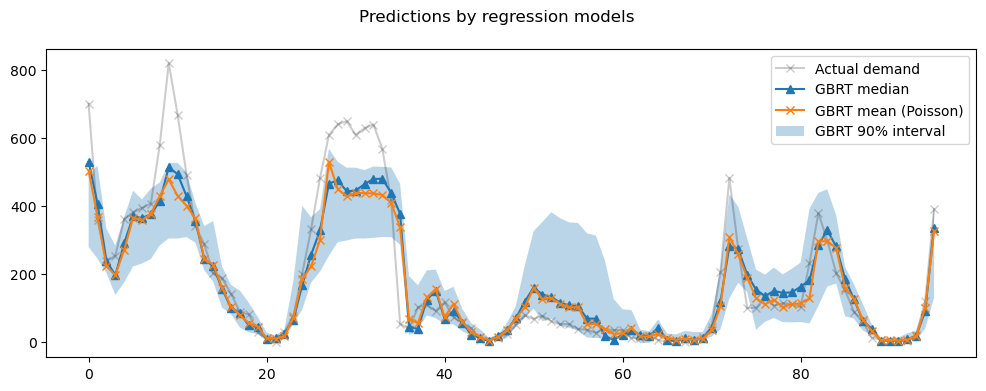

In [76]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    median_predictions[last_hours],
    "^-",
    label="GBRT median",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    percentile_5_predictions[last_hours],
    percentile_95_predictions[last_hours],
    alpha=0.3,
    label="GBRT 90% interval"
)
_ = ax.legend()

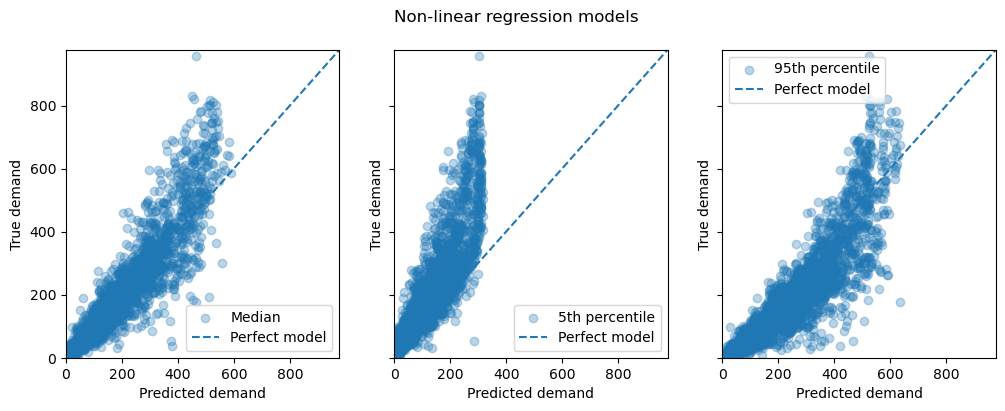

In [77]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    median_predictions,
    percentile_5_predictions,
    percentile_95_predictions,
]
labels = [
    "Median",
    "5th percentile",
    "95th percentile",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(pred, y_test.values, alpha=0.3, label=label)
    ax.plot([0, y.max()], [0, y.max()], "--", label="Perfect model")
    ax.set(
        xlim=(0, y.max()),
        ylim=(0, y.max()),
        xlabel="Predicted demand",
        ylabel="True demand",
    )
    ax.legend()

plt.show()

### Assessing Quantile Calibration by Measuring the Effective Coverage

We can evaluate if our quantile estimates are well calibrated by assessing

In [78]:
(median_predictions > y_test).mean()

0.5073333333333333

In [79]:
(percentile_5_predictions > y_test).mean()

0.10266666666666667

In [80]:
(percentile_95_predictions > y_test).mean()

0.8613333333333333

In [81]:
np.logical_and(
    percentile_5_predictions < y_test,
    percentile_95_predictions > y_test,
).mean()

0.7586666666666667

### Questions

- Which of the previous quantile estimates appear well-calibrated?
- Is the uncertainty band estimated between the low and high quantiles too wide or too narrow?

### Analysis

The pinball loss is guaranteed to be minimized by models that estimate the quantiles perfectly. However in practice this is an asymptotic property (with access to an infinite number of data points).

When the number of samples is limited, models with the same pinball loss can trade calibration for ranking power: one extreme case would be to compute the quantiles of `y_train` independently of `X_train`. This will yield a well calibrated quantile estimator with an worseless ranking power.

Therefore one cannot always trust the prediction intervals returned by quantiles estimators with a non-zero pinball loss.

### Possible Improvements

As usual, we can probably improve our estimators by:

- collecting more data-points;
- better tuning of the model hyper-parameters (e.g. `max_iter=300`, `max_leaf_nodes=64`);
- engineering more predictive features from the same data (could be useful for quantile regression linear models not covered in this tutorial).

It is also possible to make uncertainty estimation easier by reducing the randomness in the forecasting problem by adding more informative features (larger lagged feature windows or external context variables like weather data).

Alternatively, it's also possible to try uncertainty estimation based on conformal predictions. For instance with [MAPIE](https://github.com/scikit-learn-contrib/MAPIE). MAPIE estimates both aleatoric and epistemic uncertainty:

- aleatoric uncertainty stems from the fact that not all `y` can ever be predicted from the limitted information available in `X` (e.g. lack of wheather data for the next hour),
- epistemic uncertainty stems from the fact that we build our estimators from a finite sample of data points that do not cover all the possible situations.

Aleatoric uncertainty is what remains even when the number of data-points goes to infinity.

### Exercise

- Wrap our `HistGradientBoostingRegressor(loss="poisson")` estimator into the `mapie.regression.MapieRegressor` meta-estimators.
- Read the documentation of MAPIE linked above to predict a 90% prediction interval;
- Measure the actual coverage of that interval on a test set;
- Plot the prediction interval on the `last_hours` slice of the test set.

Questions: is this better than results obtained directly by quantile regression?

In [84]:
%pip install -q MAPIE

Note: you may need to restart the kernel to use updated packages.


In [ ]:
from mapie.regression import MapieRegressor


# TODO your code here



















### Solution

In [97]:
from mapie.regression import MapieRegressor

gbrt_mean_poisson_mapie = MapieRegressor(HistGradientBoostingRegressor(loss="poisson"))
gbrt_mean_poisson_mapie.fit(X_train, y_train)
mean_predictions, predictions_90_pi = gbrt_mean_poisson_mapie.predict(X_test, alpha=0.1)
predictions_90_pi_low = predictions_90_pi[:, 0].ravel()
predictions_90_pi_high = predictions_90_pi[:, 1].ravel()

In [98]:
np.logical_and(
    predictions_90_pi_low < y_test,
    predictions_90_pi_high > y_test,
).mean()


0.8536666666666667

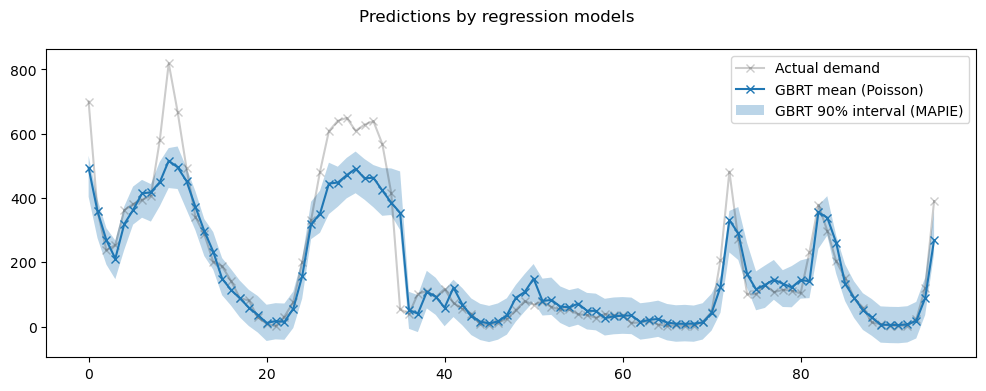

In [99]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by regression models")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    mean_predictions[last_hours],
    "x-",
    label="GBRT mean (Poisson)",
)
ax.fill_between(
    np.arange(96),
    predictions_90_pi_low[last_hours],
    predictions_90_pi_high[last_hours],
    alpha=0.3,
    label="GBRT 90% interval (MAPIE)"
)
_ = ax.legend()

## Inspecting the Most Predictive Features

In this last section we redo the full pipeline with a richer lagged feature set.

We then use the `permutation_importance` tool of scikit-learn to mine which features are the most predictive.

In [109]:
lagged_df = pd.concat(
    [count]
    + [count.shift(i).rename(f"lagged_count_{i}h") for i in range(1, 48)]
    + [count.shift(7 * 24 + i).rename(f"lagged_count_7d_{i}h") for i in range(0, 48)]
    + [
        count.shift(1).rolling(24).mean().rename("lagged_mean_24h"),
        count.shift(1).rolling(24).max().rename("lagged_max_24h"),
        count.shift(1).rolling(24).min().rename("lagged_min_24h"),
        count.shift(1).rolling(7 * 24).mean().rename("lagged_mean_7d"),
        count.shift(1).rolling(7 * 24).max().rename("lagged_max_7d"),
        count.shift(1).rolling(7 * 24).min().rename("lagged_min_7d"),
    ],
    axis="columns",
).dropna()

X = lagged_df.drop("count", axis="columns")
y = lagged_df["count"]

In [111]:
X.shape

(17164, 101)

In [116]:

evaluate(HistGradientBoostingRegressor(loss="poisson", max_leaf_nodes=64, max_iter=300), X, y, cv=ts_cv)

mean_absolute_percentage_error: 0.278 ± 0.063
root_mean_squared_error: 61.840 ± 4.532
mean_absolute_error: 37.098 ± 3.414
mean_pinball_05_loss: 12.640 ± 1.228
mean_pinball_50_loss: 18.549 ± 1.707
mean_pinball_95_loss: 24.458 ± 3.642

done in 19.693 s


In [119]:
train_idx, test_idx = next(ts_cv.split(X, y))
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

gbrt_mean_poisson = HistGradientBoostingRegressor(loss="poisson")
gbrt_mean_poisson.fit(X_train, y_train)

HistGradientBoostingRegressor(loss='poisson')

In [120]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import check_scoring


def boxplot_importances(model, X, y, scoring="r2", **kwargs):
    pi_results = permutation_importance(model, X, y, scoring=scoring, **kwargs)

    sorted_importances_idx = pi_results.importances_mean.argsort()[-15:]
    importances = pd.DataFrame(
        pi_results.importances[sorted_importances_idx].T,
        columns=X.columns[sorted_importances_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ref_score = check_scoring(model, scoring)(model, X, y)
    ax.set_xlabel(f"Decrease in score (reference: {ref_score:.3f})")
    ax.figure.tight_layout()

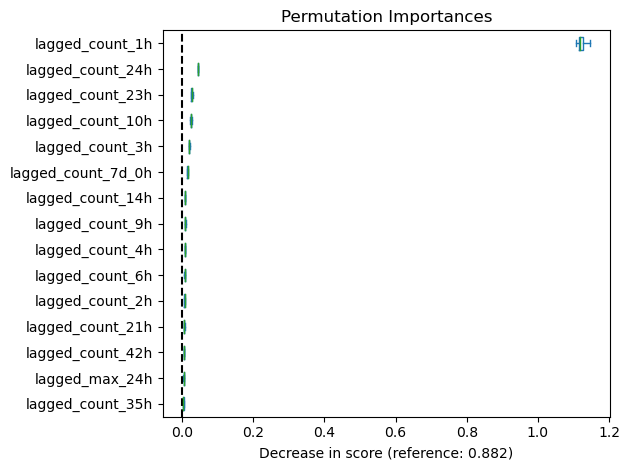

In [121]:
boxplot_importances(gbrt_mean_poisson, X_test, y_test, scoring="r2")

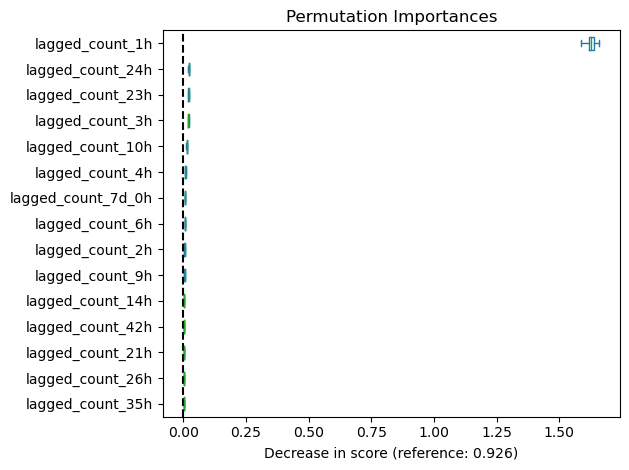

In [118]:
from sklearn.metrics import d2_tweedie_score
from functools import partial
from sklearn.metrics import make_scorer

d2_poisson_score = make_scorer(partial(d2_tweedie_score, power=1))
boxplot_importances(
    gbrt_mean_poisson, X_test, y_test, scoring=d2_poisson_score
)

One could conduct similar analysis for the quantile regressors using the `pinball_loss` by passing the `alpha` parameter to `make_scorer`.

In [122]:
# TODO:
# - integrate additional features from the original dataset
# - error analysis:
#   - hourly MAPE averaged accross a week
#   - hourly MAD averaged accross a week
#   - hourly bias averaged accross a week
#   - hourly bias for a working day
#   - hourly bias for a non-working day
# - recursive predictions at a given forecast horizon using `sktime``
